## Imports and Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import integrate, signal
import sympy

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Functions

In [3]:
def photons_from_temp(ω_c, temp):
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω_c / temp) - 1) ** -1

In [4]:
def temp_from_photons(ω_c, num_photons):
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω_c / np.log(1 / num_photons + 1)

In [5]:
def get_photons_a_no_NV(ω_bounds, κ, γ, ϕ, nT, β, Sϕ):
    """
    function for calculating the number of phonts in output a (i.e. reflection) when the NV ensemble is not connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param nT:        the number of thermal photons from the environment
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # Noise part first
    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    noise_term = (κ * γ * nT + κ * ϕ + np.abs((κ - γ - ϕ) / 2 + 1j * ω_bounds) ** 2 * nT) / den
    noise_photons = integrate.simpson(noise_term, x=ω_bounds)

    phase_noise_photons = integrate.simpson(np.abs((κ - γ - ϕ) / 2 + 1j * ω_bounds) ** 2  / den * Sϕ, x=ω_bounds)

    noise_photons += phase_noise_photons

    # Now signal term
    signal_photons = np.abs((κ - γ - ϕ) / 2) ** 2  / np.abs((κ + γ + ϕ) / 2) ** 2 * np.abs(β) ** 2

    return noise_photons, signal_photons, noise_photons + signal_photons

In [6]:
def get_photons_e_no_NV(ω_bounds, κ, γ, ϕ, nT, β, Sϕ):
    """
    function for calculating the number of phonts in output e (i.e. transmission) when the NV ensemble is not connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param nT:        the number of thermal photons from the environment
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # Noise part first
    noise_term = (ϕ * κ * nT + ϕ * γ * nT + np.abs((ϕ - κ - γ) / 2 + 1j * ω_bounds) ** 2) / np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    noise_photons = integrate.simpson(noise_term, x=ω_bounds)

    phase_noise_photons = integrate.simpson( ϕ * κ  / np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2 * Sϕ, x=ω_bounds)

    noise_photons += phase_noise_photons

    # Now signal term
    signal_photons = ϕ * κ  / np.abs((κ + γ + ϕ) / 2) ** 2 * np.abs(β) ** 2

    return noise_photons, signal_photons, noise_photons + signal_photons

In [7]:
def get_photons_a(ω_bounds, κ, γ, ϕ, g, r, nT, nc, β, Sϕ):
    """
    function for calculating the number of phonts in output a (i.e. reflection) when the NV ensemble is connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param g:         the collective coupling strength between the cavity and the ensemble
    :param r:         the inhomogenous broadening of the spins
    :param nT:        the number of thermal photons from the environment
    :param nc:        the effective number of photons from the cold spin ensemble
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # To do the integration, we have to separate out the β term
    β_term = np.abs(((κ - γ - ϕ) / 2) * (r / 2) - g ** 2) ** 2 / np.abs(((κ + γ + ϕ) / 2) * (r / 2) + g ** 2) ** 2 * np.abs(β) ** 2
    
    # Now set up the rest
    num = (r ** 2 / 4 + ω_bounds ** 2) * (κ * γ * nT + κ * ϕ) + κ * r * g ** 2 * nc
    num += np.abs(((κ - γ - ϕ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 * nT

    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2

    noise_term = integrate.simpson(num / den, x=ω_bounds) 
    noise_term += integrate.simpson(np.abs(((κ - γ - ϕ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 / den * Sϕ, x=ω_bounds)

    return noise_term, β_term, noise_term + β_term

In [8]:
def get_photons_e(ω_bounds, κ, γ, ϕ, g, r, nT, nc, β, Sϕ):
    """
    function for calculating the number of phonts in output a (i.e. reflection) when the NV ensemble is connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param g:         the collective coupling strength between the cavity and the ensemble
    :param r:         the inhomogenous broadening of the spins
    :param nT:        the number of thermal photons from the environment
    :param nc:        the effective number of photons from the cold spin ensemble
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # To do the integration, we need to separate out the β term
    β_term = (r ** 2 / 4) * ϕ * κ / np.abs(((κ + γ + ϕ) / 2) * (r / 2) + g ** 2) ** 2 * np.abs(β) ** 2

    # Now do the rest
    num = (r ** 2 / 4 + ω_bounds ** 2) * (ϕ * κ * nT + ϕ * γ * nT) + ϕ * r * g ** 2 * nc
    num += np.abs(((ϕ - κ - γ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2

    noise_term = integrate.simpson(num / den, x=ω_bounds) 
    noise_term += integrate.simpson((r ** 2 / 4 + ω_bounds ** 2) * ϕ * κ / den * Sϕ, x=ω_bounds)
    
    return noise_term, β_term, noise_term + β_term

In [9]:
def get_output_spectrum_e(ω, κ, γ, ϕ, g, r, nT, nc, β, Sϕ):
    # Going to ignore β for now because we're just looking at the noise
    a = (r ** 2 / 4 + ω ** 2) * (ϕ * κ * nT + ϕ * γ * nT) + ϕ * r * g ** 2 * nc
    b = np.abs(((ϕ - κ - γ) / 2 + 1j * ω) * (r / 2 - 1j * ω) - g ** 2) ** 2
    c = (r ** 2 / 4 + ω ** 2) * ϕ * κ * (np.abs(β) ** 2 + Sϕ)

    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω) * (r / 2 - 1j * ω) + g ** 2) ** 2

    return (a + b + c) / den

In [10]:
def get_output_noise_spectrum_e(ω, κ, γ, ϕ, g, r, nT, nc, β, Sϕ):
    a = (r ** 2 / 4 + ω ** 2) * (ϕ * κ * nT + ϕ * γ * nT) + ϕ * r * g ** 2 * nc
    b = np.abs(((ϕ - κ - γ) / 2 + 1j * ω) * (r / 2 - 1j * ω) - g ** 2) ** 2

    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω) * (r / 2 - 1j * ω) + g ** 2) ** 2

    return (a + b) / den + (r ** 2 / 4 + ω ** 2) * ϕ * κ / den * Sϕ

In [11]:
def get_output_signal_spectrum_e(ω, κ, γ, ϕ, g, r, nT, nc, β):
    c = (r ** 2 / 4 + ω ** 2) * ϕ * κ * np.abs(β) ** 2

    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω) * (r / 2 - 1j * ω) + g ** 2) ** 2

    return c / den

In [12]:
def get_output_spectrum_e_no_NV(ω, κ, γ, ϕ, nT, β, Sϕ):
    a = ϕ * κ * nT + ϕ * γ * nT
    b = np.abs((ϕ - κ - γ) / 2 + 1j * ω) ** 2
    c = ϕ * κ * (np.abs(β) ** 2 + Sϕ)

    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω) ** 2

    return (a + b + c) / den

In [13]:
def get_output_noise_spectrum_e_no_NV(ω, κ, γ, ϕ, nT, β, Sϕ):
    a = ϕ * κ * nT + ϕ * γ * nT
    b = np.abs((ϕ - κ - γ) / 2 + 1j * ω) ** 2

    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω) ** 2

    return (a + b) / den + ϕ * κ / den * Sϕ

In [14]:
def get_output_signal_spectrum_e_no_NV(ω, κ, γ, ϕ, nT, β):
    c = ϕ * κ * np.abs(β) ** 2

    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω) ** 2

    return c / den

In [65]:
def S_signal_NV(ω, κ, γ, ϕ, r, g, nT, nc, β, S_signal_noNV):
    B = (κ + γ + ϕ) / 2 - 1j * ω
    C = r / 2 - 1j * ω
    num = 2 * (B * C).real * g ** 2 + g ** 4
    den = np.abs(B) ** 2 * np.abs(C) ** 2

    return 1 / (1 + num / den) * S_signal_noNV

In [66]:
def S_noise_NV(ω, κ, γ, ϕ, r, g, nT, nc, β, S_noise_noNV):
    B = (κ + γ + ϕ) / 2 - 1j * ω
    C = r / 2 - 1j * ω
    D = (ϕ - κ - γ) / 2 + 1j * ω
    
    num = 2 * (B*C).real * g ** 2 + g ** 4
    den = np.abs(B) ** 2 * np.abs(C) ** 2

    num_b = ϕ * r * g ** 2 * nc - 2 * (D * C).real * g ** 2 + g ** 4
    den_b = den + num

    return 1 / (1 + num / den) * S_noise_noNV + num_b / den_b

## Calculations

In [17]:
# Define parameters
ωc = 2.87 * 2 * np.pi * 1e9
g = 2 * np.pi * 197.7e3
r = 2 * np.pi * 229e3
γ = 2 * np.pi * 140e3
κ = 2 * np.pi * 185.1e3
P = 0.8
nc = 0.5 * (1 - P) / P
T = 5
nT = photons_from_temp(ωc, T)
ϕ = (κ + γ) / 2
β = np.sqrt(1e10)

# Set the power spectral density for the phase noise to a constant - we'll use half of nT for now
ω_bounds = np.linspace(-γ, γ, 1000)
Sϕ = nT / 2 * np.ones(ω_bounds.shape[0])

### a) How does SNR compare between the two as $\beta$ changes?

In [18]:
# First set up β range
β_vals = np.sqrt(np.logspace(6, 10, 1000))

# Define bounds on ω
ω_bounds = np.linspace(-γ, γ, 1000)

In [19]:
# Calculate the input noise using γ as the linewidth
input_noise = (ω_bounds[-1] - ω_bounds[0]) * (2 * nT + nc + 1)
input_noise += integrate.simpson(Sϕ, x=ω_bounds)
print("Input noise photons: %.3e" % input_noise)

# Calculate the input signal from the β values
input_signal_vals = np.abs(β_vals) ** 2

# Calculate the initial SNR - this will be the same for both cavity configurations
input_snr_vals = input_signal_vals / input_noise

Input noise photons: 1.594e+08


In [20]:
# Calculate the output noise and signal for the cavity with no NV ensemble
output_noise_no_nv_vals = []
output_signal_no_nv_vals = []
for b in β_vals:
    temp = get_photons_e_no_NV(ω_bounds, κ, γ, ϕ, nT, b, Sϕ)
    output_noise_no_nv_vals.append(temp[0])
    output_signal_no_nv_vals.append(temp[1])

output_noise_no_nv_vals = np.array(output_noise_no_nv_vals)
print("output noise photons no NV: %.3e" % output_noise_no_nv_vals[0])
output_signal_no_nv_vals = np.array(output_signal_no_nv_vals)
print("output signal photons no NV: %.3e" % output_signal_no_nv_vals[0])
output_snr_no_nv_vals = output_signal_no_nv_vals / output_noise_no_nv_vals

output noise photons no NV: 6.563e+07
output signal photons no NV: 5.061e+05


In [21]:
# Calculate the output noise and signal for the cavity with the NV ensemble
output_noise_vals = []
output_signal_vals = []
for b in β_vals:
    temp = get_photons_e(ω_bounds, κ, γ, ϕ, g, r, nT, nc, b, Sϕ)
    output_noise_vals.append(temp[0])
    output_signal_vals.append(temp[1])

output_noise_vals = np.array(output_noise_vals)
print("output noise photons: %.3e" % output_noise_vals[0])
output_signal_vals = np.array(output_signal_vals)
print("output signal photons: %.3e" % output_signal_vals[0])
output_snr_vals = output_signal_vals / output_noise_vals

output noise photons: 1.933e+07
output signal photons: 8.786e+04


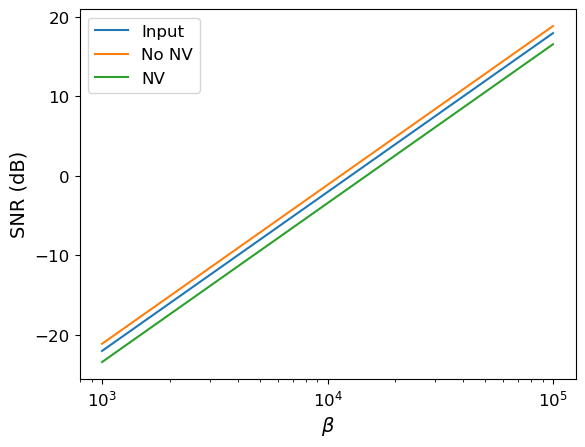

In [22]:
plt.plot(β_vals, 10*np.log10(input_snr_vals), label='Input')
plt.plot(β_vals, 10*np.log10(output_snr_no_nv_vals), label='No NV')
plt.plot(β_vals, 10*np.log10(output_snr_vals), label='NV')
plt.xlabel("$\\beta$")
plt.ylabel("SNR (dB)")
plt.xscale('log')
plt.legend()

### b) What about $\kappa$?

Text(0.5, 0, '$\\omega$ (MHz)')

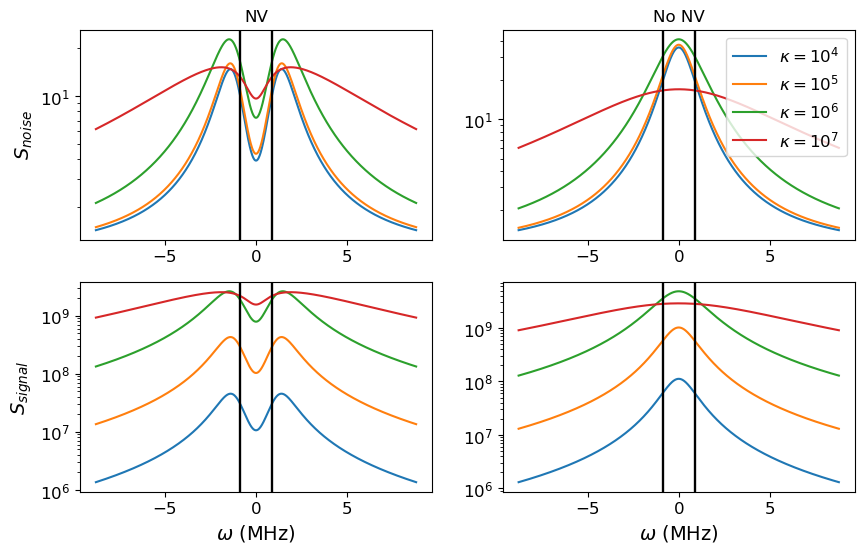

In [23]:
# Let's look at the spectra first
κ_vals = [1e4, 1e5, 1e6, 1e7]
s_noise_out_vals = []
s_signal_out_vals = []
s_noise_out_no_NV_vals = []
s_signal_out_no_NV_vals = []
for k in κ_vals:
    s_noise_out_vals.append(get_output_noise_spectrum_e(10*ω_bounds, k, γ, ϕ, g, r, nT, nc, β, Sϕ))
    s_signal_out_vals.append(get_output_signal_spectrum_e(10*ω_bounds, k, γ, ϕ, g, r, nT, nc, β))
    s_noise_out_no_NV_vals.append(get_output_noise_spectrum_e_no_NV(10*ω_bounds, k, γ, ϕ, nT, β, Sϕ))
    s_signal_out_no_NV_vals.append(get_output_signal_spectrum_e_no_NV(10*ω_bounds, k, γ, ϕ, nT, β))

#linestyles = ['-', (0, (5, 10)), (0, (5, 7.5)), (0, (5, 5)), (0, (5, 2.5))] 
linestyles = ['-', '-', '-', '-']
fig = plt.figure(1, figsize=(10, 6))
ax = fig.subplots(2, 2)
for i, k in enumerate(κ_vals):
    ax[0][0].semilogy(10*ω_bounds / 1e6, s_noise_out_vals[i], linestyle=linestyles[i])
    ax[0][0].axvline(x=-γ/1e6, color='k')
    ax[0][0].axvline(x=γ/1e6, color='k')

    ax[0][1].semilogy(10*ω_bounds / 1e6, s_noise_out_no_NV_vals[i], linestyle=linestyles[i], label='$\\kappa = 10^{' + str(i+4) + '}$')
    ax[0][1].axvline(x=-γ/1e6, color='k')
    ax[0][1].axvline(x=γ/1e6, color='k')

    ax[1][0].semilogy(10*ω_bounds / 1e6, s_signal_out_vals[i], linestyle=linestyles[i])
    ax[1][0].axvline(x=-γ/1e6, color='k')
    ax[1][0].axvline(x=γ/1e6, color='k')

    ax[1][1].semilogy(10*ω_bounds / 1e6, s_signal_out_no_NV_vals[i], linestyle=linestyles[i])
    ax[1][1].axvline(x=-γ/1e6, color='k')
    ax[1][1].axvline(x=γ/1e6, color='k')

ax[0][0].set_ylabel("$S_{noise}$")
ax[0][0].set_title("NV")
ax[0][1].set_title("No NV")
ax[0][1].legend()
ax[1][0].set_ylabel("$S_{signal}$")
ax[1][0].set_xlabel("$\\omega$ (MHz)")
ax[1][1].set_xlabel("$\\omega$ (MHz)")

In [24]:
# Define κ values
κ_vals = np.logspace(4, 7, 1000)

In [25]:
# Define the input noise
input_noise = 0#(ω_bounds[-1] - ω_bounds[0]) * (2*nT + nc + 1)
input_noise += integrate.simpson(Sϕ, x=ω_bounds)

# Define the input signal
input_signal = np.abs(β) ** 2

# Calculate the input snr
input_snr = input_signal / input_noise

In [26]:
# Calculate the output noise and signal for each κ value with no NV ensemble
output_noise_no_NV_vals = np.zeros(κ_vals.shape[0])
output_signal_no_NV_vals = np.zeros(κ_vals.shape[0])
for i, k in enumerate(κ_vals):
    temp = get_photons_e_no_NV(ω_bounds, k, γ, ϕ, nT, β, Sϕ)
    output_noise_no_NV_vals[i] = temp[0]
    output_signal_no_NV_vals[i] = temp[1]

# Calculate SNR
output_snr_no_NV_vals = output_signal_no_NV_vals / output_noise_no_NV_vals

In [27]:
# Calculate the output noise and signal for each κ value with NV ensemble
output_noise_vals = np.zeros(κ_vals.shape[0])
output_signal_vals = np.zeros(κ_vals.shape[0])
for i, k in enumerate(κ_vals):
    temp = get_photons_e(ω_bounds, k, γ, ϕ, g, r, nT, nc, β, Sϕ)
    output_noise_vals[i] = temp[0]
    output_signal_vals[i] = temp[1]

# Calculate SNR
output_snr_vals = output_signal_vals / output_noise_vals

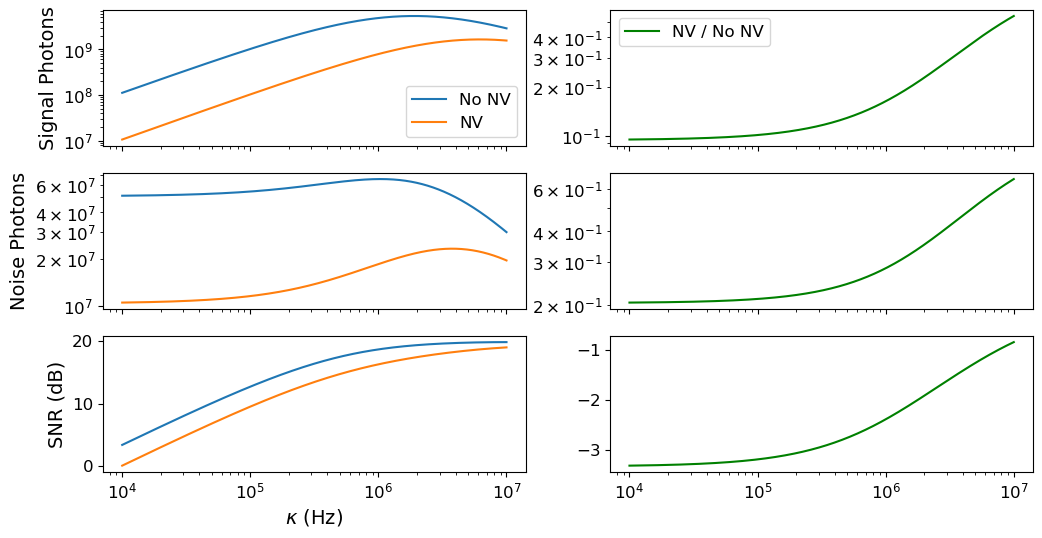

In [28]:
# Plot
fig = plt.figure(1, figsize=(12,6))
ax = fig.subplots(3, 2, sharex='all')
ax[0][0].semilogx(κ_vals, output_signal_no_NV_vals, label='No NV')
ax[0][0].semilogx(κ_vals, output_signal_vals, label='NV')
ax[0][0].set_ylabel("Signal Photons")
ax[0][0].set_yscale('log')
ax[0][0].legend()

ax[0][1].semilogx(κ_vals, output_signal_vals / output_signal_no_NV_vals, 'g-', label="NV / No NV")
ax[0][1].set_yscale('log')
ax[0][1].legend()

ax[1][0].semilogx(κ_vals, output_noise_no_NV_vals)
ax[1][0].semilogx(κ_vals, output_noise_vals)
ax[1][0].set_ylabel("Noise Photons")
ax[1][0].set_yscale('log')

ax[1][1].semilogx(κ_vals, output_noise_vals / output_noise_no_NV_vals, 'g-')
ax[1][1].set_yscale('log')

ax[2][0].semilogx(κ_vals, 10*np.log10(output_snr_no_NV_vals))
ax[2][0].semilogx(κ_vals, 10*np.log10(output_snr_vals))
ax[2][0].set_ylabel("SNR (dB)")
ax[2][0].set_xlabel("$\\kappa$ (Hz)")

ax[2][1].semilogx(κ_vals, 10*np.log10(output_snr_vals / output_snr_no_NV_vals), 'g-')

### c) What about $\phi$?

Text(0.5, 0, '$\\omega$ (MHz)')

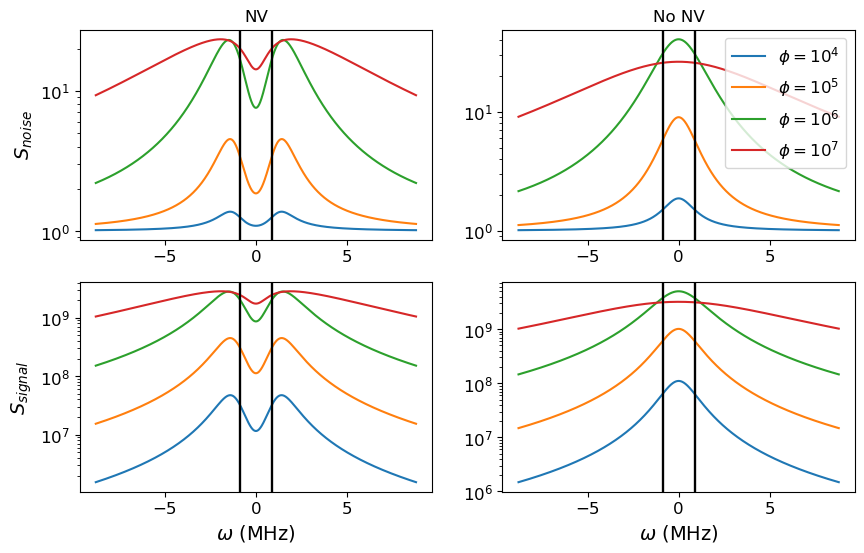

In [29]:
# Let's look at the spectra first
ϕ_vals = [1e4, 1e5, 1e6, 1e7]
s_noise_out_vals = []
s_signal_out_vals = []
s_noise_out_no_NV_vals = []
s_signal_out_no_NV_vals = []
for p in ϕ_vals:
    s_noise_out_vals.append(get_output_noise_spectrum_e(10*ω_bounds, κ, γ, p, g, r, nT, nc, β, Sϕ))
    s_signal_out_vals.append(get_output_signal_spectrum_e(10*ω_bounds, κ, γ, p, g, r, nT, nc, β))
    s_noise_out_no_NV_vals.append(get_output_noise_spectrum_e_no_NV(10*ω_bounds, κ, γ, p, nT, β, Sϕ))
    s_signal_out_no_NV_vals.append(get_output_signal_spectrum_e_no_NV(10*ω_bounds, κ, γ, p, nT, β))

#linestyles = ['-', (0, (5, 10)), (0, (5, 7.5)), (0, (5, 5)), (0, (5, 2.5))] 
linestyles = ['-', '-', '-', '-']
fig = plt.figure(1, figsize=(10, 6))
ax = fig.subplots(2, 2)
for i, p in enumerate(ϕ_vals):
    ax[0][0].semilogy(10*ω_bounds / 1e6, s_noise_out_vals[i], linestyle=linestyles[i])
    ax[0][0].axvline(x=-γ/1e6, color='k')
    ax[0][0].axvline(x=γ/1e6, color='k')

    ax[0][1].semilogy(10*ω_bounds / 1e6, s_noise_out_no_NV_vals[i], linestyle=linestyles[i], label='$\\phi = 10^{' + str(i+4) + '}$')
    ax[0][1].axvline(x=-γ/1e6, color='k')
    ax[0][1].axvline(x=γ/1e6, color='k')

    ax[1][0].semilogy(10*ω_bounds / 1e6, s_signal_out_vals[i], linestyle=linestyles[i])
    ax[1][0].axvline(x=-γ/1e6, color='k')
    ax[1][0].axvline(x=γ/1e6, color='k')

    ax[1][1].semilogy(10*ω_bounds / 1e6, s_signal_out_no_NV_vals[i], linestyle=linestyles[i])
    ax[1][1].axvline(x=-γ/1e6, color='k')
    ax[1][1].axvline(x=γ/1e6, color='k')

ax[0][0].set_ylabel("$S_{noise}$")
ax[0][0].set_title("NV")
ax[0][1].set_title("No NV")
ax[0][1].legend()
ax[1][0].set_ylabel("$S_{signal}$")
ax[1][0].set_xlabel("$\\omega$ (MHz)")
ax[1][1].set_xlabel("$\\omega$ (MHz)")

In [30]:
# Define ϕ values
ϕ_vals = np.logspace(4, 7, 1000)

In [31]:
# Define the input noise
input_noise = 0#(ω_bounds[-1] - ω_bounds[0]) * (2 * nT + nc + 1)
input_noise += integrate.simpson(Sϕ, x=ω_bounds)

# Define the input signal
input_signal = np.abs(β) ** 2

# Calculate the input snr
input_snr = input_signal / input_noise

In [32]:
# Calculate the output noise and signal for each κ value with no NV ensemble
output_noise_no_NV_vals = np.zeros(ϕ_vals.shape[0])
output_signal_no_NV_vals = np.zeros(ϕ_vals.shape[0])
for i, p in enumerate(ϕ_vals):
    temp = get_photons_e_no_NV(ω_bounds, κ, γ, p, nT, β, Sϕ)
    output_noise_no_NV_vals[i] = temp[0]
    output_signal_no_NV_vals[i] = temp[1]

# Calculate SNR
output_snr_no_NV_vals = output_signal_no_NV_vals / output_noise_no_NV_vals

In [33]:
# Calculate the output noise and signal for each κ value with NV ensemble
output_noise_vals = np.zeros(ϕ_vals.shape[0])
output_signal_vals = np.zeros(ϕ_vals.shape[0])
for i, p in enumerate(ϕ_vals):
    temp = get_photons_e(ω_bounds, κ, γ, p, g, r, nT, nc, β, Sϕ)
    output_noise_vals[i] = temp[0]
    output_signal_vals[i] = temp[1]

# Calculate SNR
output_snr_vals = output_signal_vals / output_noise_vals

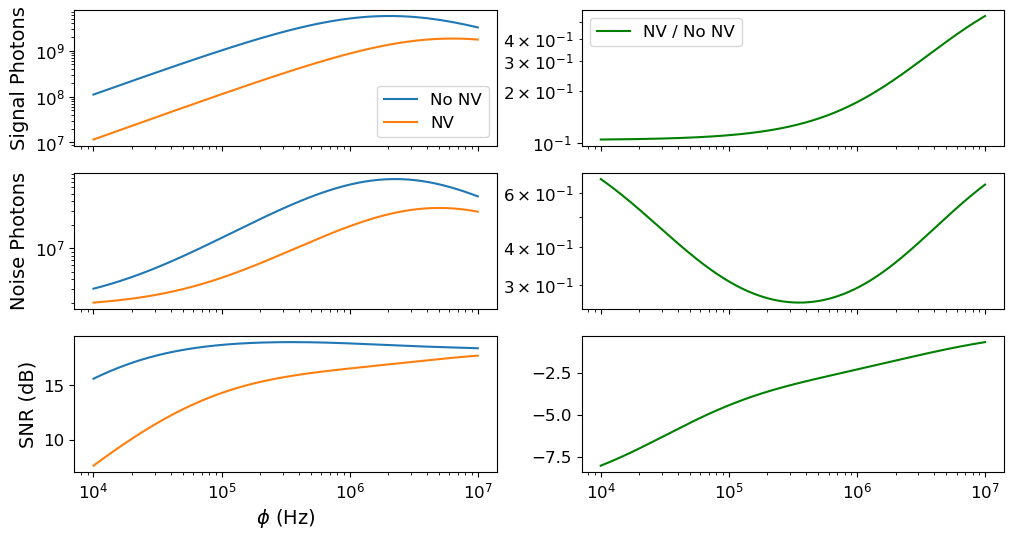

In [34]:
# Plot
fig = plt.figure(1, figsize=(12,6))
ax = fig.subplots(3, 2, sharex='all')
ax[0][0].semilogx(ϕ_vals, output_signal_no_NV_vals, label='No NV')
ax[0][0].semilogx(ϕ_vals, output_signal_vals, label='NV')
ax[0][0].set_ylabel("Signal Photons")
ax[0][0].set_yscale('log')
ax[0][0].legend()

ax[0][1].semilogx(ϕ_vals, output_signal_vals / output_signal_no_NV_vals, 'g-', label='NV / No NV')
ax[0][1].set_yscale('log')
ax[0][1].legend()

ax[1][0].semilogx(ϕ_vals, output_noise_no_NV_vals)
ax[1][0].semilogx(ϕ_vals, output_noise_vals)
ax[1][0].set_ylabel("Noise Photons")
ax[1][0].set_yscale('log')

ax[1][1].semilogx(ϕ_vals, output_noise_vals / output_noise_no_NV_vals, 'g-')
ax[1][1].set_yscale('log')

ax[2][0].semilogx(ϕ_vals, 10*np.log10(output_snr_no_NV_vals))
ax[2][0].semilogx(ϕ_vals, 10*np.log10(output_snr_vals))
ax[2][0].set_ylabel("SNR (dB)")
ax[2][0].set_xlabel("$\\phi$ (Hz)")

ax[2][1].semilogx(ϕ_vals, 10*np.log10(output_snr_vals / output_snr_no_NV_vals), 'g-')

### d) What about changing g and r?

Text(0.5, 0, '$\\omega$ (MHz)')

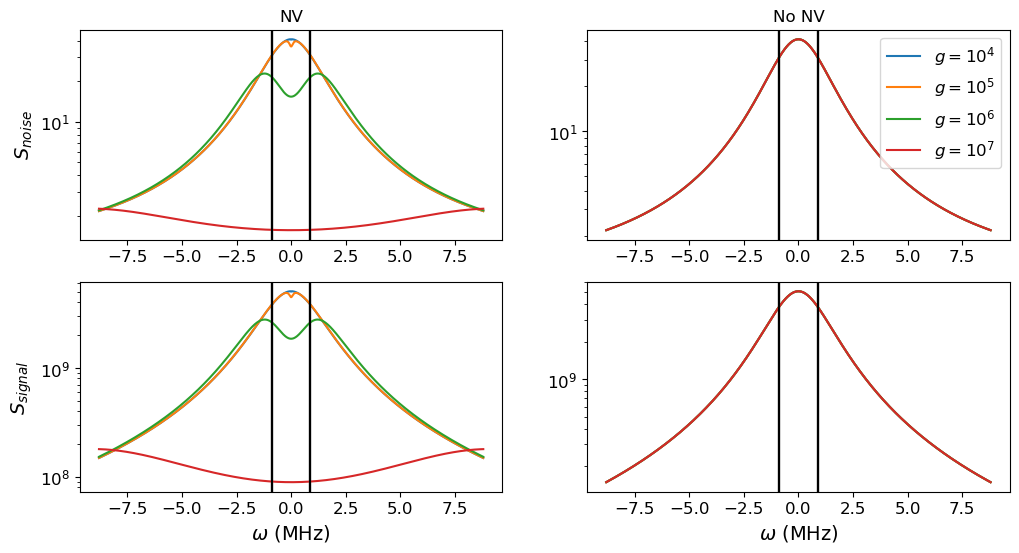

In [35]:
# Let's look at the spectra first
g_vals = [1e4, 1e5, 1e6, 1e7]
s_noise_out_vals = []
s_signal_out_vals = []
s_noise_out_no_NV_vals = []
s_signal_out_no_NV_vals = []
for g in g_vals:
    s_noise_out_vals.append(get_output_noise_spectrum_e(10*ω_bounds, κ, γ, ϕ, g, 2*g, nT, nc, β, Sϕ))
    s_signal_out_vals.append(get_output_signal_spectrum_e(10*ω_bounds, κ, γ, ϕ, g, 2*g, nT, nc, β))
    s_noise_out_no_NV_vals.append(get_output_noise_spectrum_e_no_NV(10*ω_bounds, κ, γ, ϕ, nT, β, Sϕ))
    s_signal_out_no_NV_vals.append(get_output_signal_spectrum_e_no_NV(10*ω_bounds, κ, γ, ϕ, nT, β))

#linestyles = ['-', (0, (5, 10)), (0, (5, 7.5)), (0, (5, 5)), (0, (5, 2.5))] 
linestyles = ['-', '-', '-', '-']
fig = plt.figure(1, figsize=(12, 6))
ax = fig.subplots(2, 2)
for i, g in enumerate(g_vals):
    ax[0][0].semilogy(10*ω_bounds / 1e6, s_noise_out_vals[i], linestyle=linestyles[i])
    ax[0][0].axvline(x=-γ/1e6, color='k')
    ax[0][0].axvline(x=γ/1e6, color='k')

    ax[0][1].semilogy(10*ω_bounds / 1e6, s_noise_out_no_NV_vals[i], linestyle=linestyles[i], label='$g = 10^{' + str(i+4) + '}$')
    ax[0][1].axvline(x=-γ/1e6, color='k')
    ax[0][1].axvline(x=γ/1e6, color='k')

    ax[1][0].semilogy(10*ω_bounds / 1e6, s_signal_out_vals[i], linestyle=linestyles[i])
    ax[1][0].axvline(x=-γ/1e6, color='k')
    ax[1][0].axvline(x=γ/1e6, color='k')

    ax[1][1].semilogy(10*ω_bounds / 1e6, s_signal_out_no_NV_vals[i], linestyle=linestyles[i])
    ax[1][1].axvline(x=-γ/1e6, color='k')
    ax[1][1].axvline(x=γ/1e6, color='k')

ax[0][0].set_ylabel("$S_{noise}$")
ax[0][0].set_title("NV")
ax[0][1].set_title("No NV")
ax[0][1].legend()
ax[1][0].set_ylabel("$S_{signal}$")
ax[1][0].set_xlabel("$\\omega$ (MHz)")
ax[1][1].set_xlabel("$\\omega$ (MHz)")

In [36]:
# Define g and r
g_vals = np.logspace(4, 7, 1000)
r_vals = 2 * g_vals

In [37]:
# Define the input noise
input_noise = 0#(ω_bounds[-1] - ω_bounds[0]) * (2 * nT + nc + 1)
input_noise += integrate.simpson(Sϕ, x=ω_bounds)

# Define the input signal
input_signal = np.abs(β) ** 2

# Calculate the input snr
input_snr = input_signal / input_noise

In [38]:
# The output snr for the cavity without the NV ensemble won't change here
output_noise_no_NV_vals, output_signal_no_NV_vals, total = get_photons_e_no_NV(ω_bounds, κ, γ, ϕ, nT, β, Sϕ)
output_snr_no_NV_vals = output_signal_no_NV_vals / output_noise_no_NV_vals

In [39]:
# Now calculate the output noise and signal for the case with the NV ensemble
output_noise_vals = np.zeros(g_vals.shape[0])
output_signal_vals = np.zeros(g_vals.shape[0])
for i in range(g_vals.shape[0]):
    temp = get_photons_e(ω_bounds, κ, γ, ϕ, g_vals[i], r_vals[i], nT, nc, β, Sϕ)
    output_noise_vals[i] = temp[0]
    output_signal_vals[i] = temp[1]

output_snr_vals = output_signal_vals / output_noise_vals

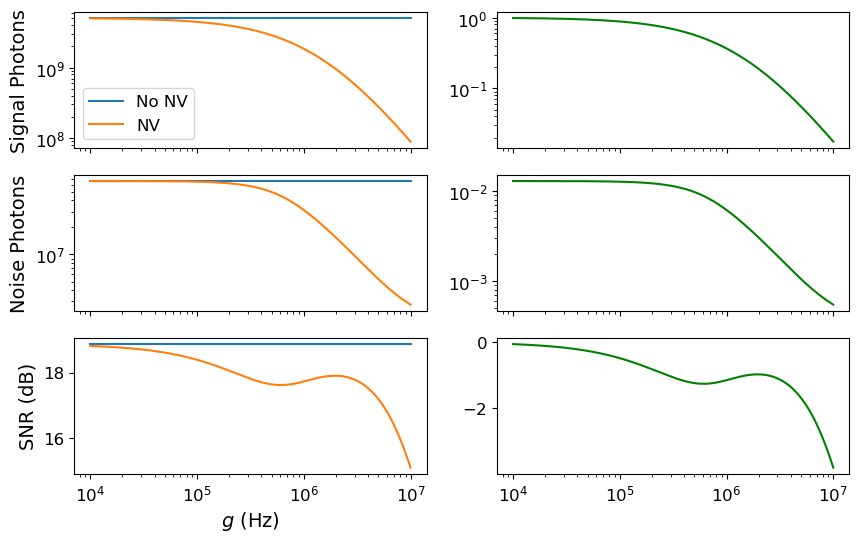

In [40]:
fig = plt.figure(1, figsize=(10,6))
ax = fig.subplots(3, 2, sharex='all')
ax[0][0].semilogx(g_vals, output_signal_no_NV_vals * np.ones(g_vals.shape[0]), label='No NV')
ax[0][0].semilogx(g_vals, output_signal_vals, label='NV')
ax[0][0].set_ylabel("Signal Photons")
ax[0][0].set_yscale('log')
ax[0][0].legend()

ax[0][1].semilogx(g_vals, output_signal_vals / output_signal_no_NV_vals, 'g-', label='NV / No NV')
ax[0][1].set_yscale('log')

ax[1][0].semilogx(g_vals, output_noise_no_NV_vals * np.ones(g_vals.shape[0]))
ax[1][0].semilogx(g_vals, output_noise_vals)
ax[1][0].set_ylabel("Noise Photons")
ax[1][0].set_yscale('log')

ax[1][1].semilogx(g_vals, output_noise_vals / output_signal_no_NV_vals, 'g-')
ax[1][1].set_yscale('log')

ax[2][0].semilogx(g_vals, 10*np.log10(output_snr_no_NV_vals) * np.ones(g_vals.shape[0]))
ax[2][0].semilogx(g_vals, 10*np.log10(output_snr_vals))
ax[2][0].set_ylabel("SNR (dB)")
ax[2][0].set_xlabel("$g$ (Hz)")

ax[2][1].semilogx(g_vals, 10*np.log10(output_snr_vals / output_snr_no_NV_vals), 'g-')

## Extra

What about at critical coupling $\phi = \kappa + \gamma + r$?  We'll use the same values fo $\kappa$ and $\gamma$ in both cases and assume $g=\kappa$ for now.

In [41]:
# Define parameters
κ = 1e3
γ = 1e3
g = 1e3
r = 2*g
ϕ = κ + γ + r
ω_bounds = np.linspace(-γ, γ, 1000) 

Text(0.5, 0, '$\\omega$ (kHz)')

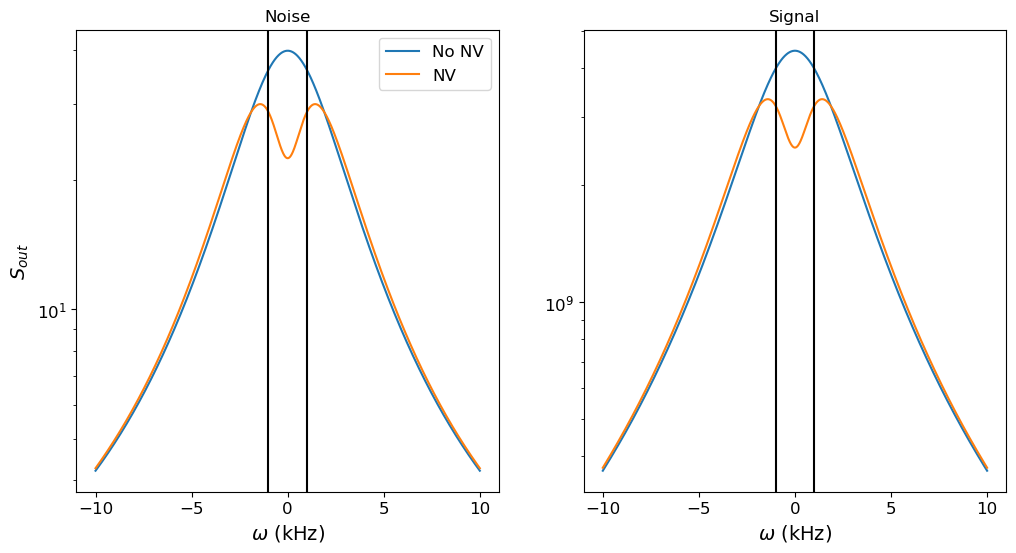

In [42]:
# Let's calculate the spectra
no_nv_output_noise_spectrum = get_output_noise_spectrum_e_no_NV(10*ω_bounds, κ, γ, ϕ, nT, β, Sϕ)
no_nv_output_signal_spectrum = get_output_signal_spectrum_e_no_NV(10*ω_bounds, κ, γ, ϕ, nT, β)

output_noise_spectrum = get_output_noise_spectrum_e(10*ω_bounds, κ, γ, ϕ, g, r, nT, nc, β, Sϕ)
output_signal_spectrum = get_output_signal_spectrum_e(10*ω_bounds, κ, γ, ϕ, g, r, nT, nc, β)

linestyles = ['-', '-', '-', '-']
fig = plt.figure(1, figsize=(12, 6))
ax = fig.subplots(1, 2)
ax[0].semilogy(10*ω_bounds / 1e3, no_nv_output_noise_spectrum, label='No NV')
ax[0].semilogy(10*ω_bounds / 1e3, output_noise_spectrum, label='NV')
ax[0].axvline(x=-γ/1e3, color='k')
ax[0].axvline(x=γ/1e3, color='k')
ax[0].legend()

ax[1].semilogy(10*ω_bounds / 1e3, no_nv_output_signal_spectrum, label='No NV')
ax[1].semilogy(10*ω_bounds / 1e3, output_signal_spectrum, label='NV')
ax[1].axvline(x=-γ/1e3, color='k')
ax[1].axvline(x=γ/1e3, color='k')

ax[0].set_ylabel("$S_{out}$")
ax[0].set_title("Noise")
ax[1].set_title("Signal")
ax[0].set_xlabel("$\\omega$ (kHz)")
ax[1].set_xlabel("$\\omega$ (kHz)")

In [43]:
# Now get the photons
no_nv_noise_photons, no_nv_signal_photons, tot = get_photons_e_no_NV(ω_bounds, κ, γ, ϕ, nT, β, Sϕ)
noise_photons, signal_photons, tot = get_photons_e(ω_bounds, κ, γ, ϕ, g, r, nT, nc, β, Sϕ)

print("No NV Noise Photons: %.3e" % no_nv_noise_photons)
print("No NV Signal Photons: %.3e" % no_nv_signal_photons)
print("No NV SNR: ", 10*np.log10(no_nv_signal_photons / no_nv_noise_photons))
print("")
print("NV Noise Photons: %.3e" % noise_photons)
print("NV Signal Photons: %.3e" % signal_photons)
print("NV SNR: ", 10*np.log10(signal_photons / noise_photons))

No NV Noise Photons: 7.707e+04
No NV Signal Photons: 4.444e+09
No NV SNR:  47.60910722547649

NV Noise Photons: 5.017e+04
NV Signal Photons: 2.500e+09
NV SNR:  46.97527460709389


What happens if the cooling is made more optimal (i.e. $g \gg \kappa + \gamma$)?

In [44]:
# Define parameters
κ = 1e2
γ = 1e2
g = 1e6
r = 2*g
ϕ = κ + γ + r
ω_bounds = np.linspace(-1e6, 1e6, 1000) 

Text(0.5, 0, '$\\omega$ (MHz)')

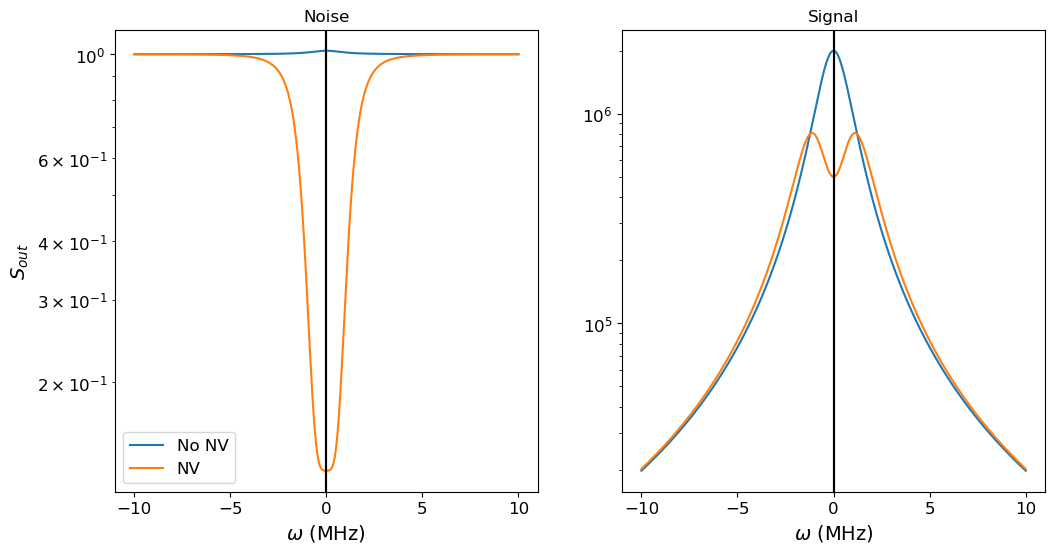

In [45]:
# Let's calculate the spectra
no_nv_output_noise_spectrum = get_output_noise_spectrum_e_no_NV(10*ω_bounds, κ, γ, ϕ, nT, β, Sϕ)
no_nv_output_signal_spectrum = get_output_signal_spectrum_e_no_NV(10*ω_bounds, κ, γ, ϕ, nT, β)

output_noise_spectrum = get_output_noise_spectrum_e(10*ω_bounds, κ, γ, ϕ, g, r, nT, nc, β, Sϕ)
output_signal_spectrum = get_output_signal_spectrum_e(10*ω_bounds, κ, γ, ϕ, g, r, nT, nc, β)

linestyles = ['-', '-', '-', '-']
fig = plt.figure(1, figsize=(12, 6))
ax = fig.subplots(1, 2)
ax[0].semilogy(10*ω_bounds / 1e6, no_nv_output_noise_spectrum, label='No NV')
ax[0].semilogy(10*ω_bounds / 1e6, output_noise_spectrum, label='NV')
ax[0].axvline(x=-γ/1e6, color='k')
ax[0].axvline(x=γ/1e6, color='k')
ax[0].legend()

ax[1].semilogy(10*ω_bounds / 1e6, no_nv_output_signal_spectrum, label='No NV')
ax[1].semilogy(10*ω_bounds / 1e6, output_signal_spectrum, label='NV')
ax[1].axvline(x=-γ/1e6, color='k')
ax[1].axvline(x=γ/1e6, color='k')

ax[0].set_ylabel("$S_{out}$")
ax[0].set_title("Noise")
ax[1].set_title("Signal")
ax[0].set_xlabel("$\\omega$ (MHz)")
ax[1].set_xlabel("$\\omega$ (MHz)")

In [46]:
# Now get the photons
no_nv_noise_photons, no_nv_signal_photons, tot = get_photons_e_no_NV(ω_bounds/1e4, κ, γ, ϕ, nT, β, Sϕ)
noise_photons, signal_photons, tot = get_photons_e(ω_bounds/1e4, κ, γ, ϕ, g, r, nT, nc, β, Sϕ)

print("No NV Noise Photons: %.3e" % no_nv_noise_photons)
print("No NV Signal Photons: %.3e" % no_nv_signal_photons)
print("No NV SNR: ", 10*np.log10(no_nv_signal_photons / no_nv_noise_photons))
print("")
print("NV Noise Photons: %.3e" % noise_photons)
print("NV Signal Photons: %.3e" % signal_photons)
print("NV SNR: ", 10*np.log10(signal_photons / noise_photons))

No NV Noise Photons: 2.035e+02
No NV Signal Photons: 1.999e+06
No NV SNR:  39.923376816620724

NV Noise Photons: 2.589e+01
NV Signal Photons: 5.000e+05
NV SNR:  42.857543492112384


In [47]:
# Now get the photons
no_nv_noise_photons, no_nv_signal_photons, tot = get_photons_e_no_NV(ω_bounds, κ, γ, ϕ, nT, β, Sϕ)
noise_photons, signal_photons, tot = get_photons_e(ω_bounds, κ, γ, ϕ, g, r, nT, nc, β, Sϕ)

print("No NV Noise Photons: %.3e" % no_nv_noise_photons)
print("No NV Signal Photons: %.3e" % no_nv_signal_photons)
print("No NV SNR: ", 10*np.log10(no_nv_signal_photons / no_nv_noise_photons))
print("")
print("NV Noise Photons: %.3e" % noise_photons)
print("NV Signal Photons: %.3e" % signal_photons)
print("NV SNR: ", 10*np.log10(signal_photons / noise_photons))

No NV Noise Photons: 2.027e+06
No NV Signal Photons: 1.999e+06
No NV SNR:  -0.06057327689794614

NV Noise Photons: 3.383e+05
NV Signal Photons: 5.000e+05
NV SNR:  1.6959022787505456


So it seems like critical coupling is required for this to perform better than the bare cavity (if the math is all correct).

I want to verify if my attempt at solving for the output spectrum of the cavity with the NV ensemble in terms of the output spectrum of the cavity without the NV ensemble is correct.  This requires breaking the output spectra into two parts: one for the noise and one for the signal.  First we'll assume that $\kappa=\gamma=\phi = 10^2$, $g=10^4$, and $r=2g$.

In [100]:
# Define parameters
ωc = 2 * np.pi * 2.87e9
κ = 1e2
γ = 1e2
ϕ = 1e8
g = 1e8
r = 2 * g
T = 5
nT = photons_from_temp(ωc, T)
P = 0.8
nc = 0.5 * (1 - P) / P
β = 1e5

In [101]:
# Set the bounds to be a bit on the larger side
ω = np.linspace(-5, 5, 1000) * 1e7

In [102]:
# Calculate the output spectra for the case where there is no NV ensemble
S_signal_noNV = get_output_signal_spectrum_e_no_NV(ω, κ, γ, ϕ, nT, β)
S_noise_noNV = get_output_noise_spectrum_e_no_NV(ω, κ, γ, ϕ, nT, β, 0)

In [103]:
# Calculate the output spectra for the case where there is the NV ensemble
exact_noise_spectrum = get_output_noise_spectrum_e(ω, κ, γ, ϕ, g, r, nT, nc, β, 0)
exact_signal_spectrum = get_output_signal_spectrum_e(ω, κ, γ, ϕ, g, r, nT, nc, β)

In [104]:
# Calculate the output spectra from the no NV spectra
calc_noise_spectrum = S_noise_NV(ω, κ, γ, ϕ, r, g, nT, nc, β, S_noise_noNV)
calc_signal_spectrum = S_signal_NV(ω, κ, γ, ϕ, r, g, nT, nc, β, S_signal_noNV)

Text(0.5, 1.0, 'Noise')

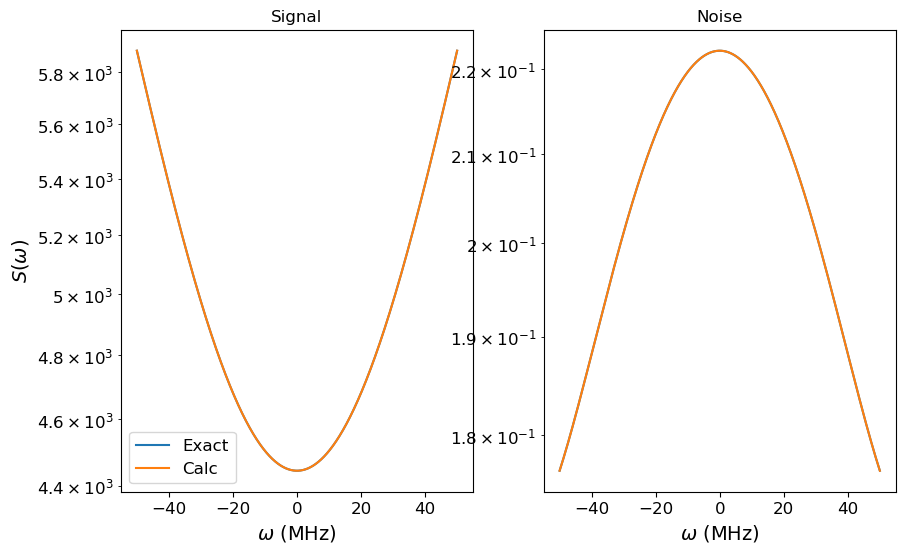

In [105]:
fig = plt.figure(1, figsize=(10,6))
ax = fig.subplots(1, 2)
ax[0].semilogy(ω / 1e6, exact_signal_spectrum, label='Exact')
ax[0].semilogy(ω / 1e6, calc_signal_spectrum, label='Calc')
ax[0].set_xlabel("$\\omega$ (MHz)")
ax[0].set_ylabel("$S(\\omega)$")
ax[0].set_title("Signal")
ax[0].legend()

ax[1].semilogy(ω / 1e6, exact_noise_spectrum)
ax[1].semilogy(ω / 1e6, calc_noise_spectrum)
ax[1].set_xlabel("$\\omega$ (MHz)")
ax[1].set_title("Noise")

Text(0.5, 1.0, 'Noise')

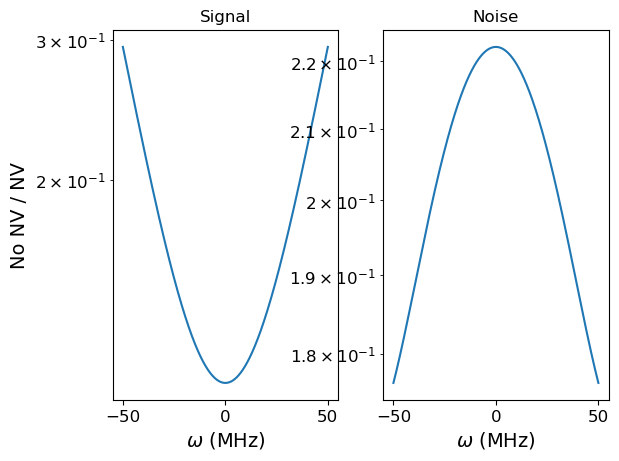

In [106]:
fig = plt.figure(1)
ax = fig.subplots(1, 2)
ax[0].semilogy(ω / 1e6, exact_signal_spectrum / S_signal_noNV)
ax[0].set_xlabel("$\\omega$ (MHz)")
ax[0].set_ylabel("No NV / NV")
ax[0].set_title("Signal")

ax[1].semilogy(ω / 1e6, exact_noise_spectrum / S_noise_noNV)
ax[1].set_xlabel("$\\omega$ (MHz)")
ax[1].set_title("Noise")